In [2]:
#build SparkSession
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Social Media Addiction Project") \
    .getOrCreate()

In [3]:
# read CSV file
df = spark.read.csv("Downloads/Students Social Media Addiction.csv", header=True, inferSchema=True)

# show first 5 rows of data
# df.show(5)
df.printSchema()

+----------+---+------+--------------+----------+---------------------+------------------+----------------------------+---------------------+-------------------+-------------------+---------------------------+--------------+
|Student_ID|Age|Gender|Academic_Level|   Country|Avg_Daily_Usage_Hours|Most_Used_Platform|Affects_Academic_Performance|Sleep_Hours_Per_Night|Mental_Health_Score|Relationship_Status|Conflicts_Over_Social_Media|Addicted_Score|
+----------+---+------+--------------+----------+---------------------+------------------+----------------------------+---------------------+-------------------+-------------------+---------------------------+--------------+
|         1| 19|Female| Undergraduate|Bangladesh|                  5.2|         Instagram|                         Yes|                  6.5|                  6|    In Relationship|                          3|             8|
|         2| 22|  Male|      Graduate|     India|                  2.1|           Twitter|          

In [4]:
# summary statistics for numeric columns
df.describe().show()

# check for missing values in each column
from pyspark.sql.functions import col, when, count
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# count distinct values for categorical fields
df.groupBy("Gender").count().show()
df.groupBy("Relationship_Status").count().show()
df.groupBy("Affects_Academic_Performance").count().show()

25/07/28 19:42:51 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+------------------+------+--------------+-----------+---------------------+------------------+----------------------------+---------------------+-------------------+-------------------+---------------------------+------------------+
|summary|       Student_ID|               Age|Gender|Academic_Level|    Country|Avg_Daily_Usage_Hours|Most_Used_Platform|Affects_Academic_Performance|Sleep_Hours_Per_Night|Mental_Health_Score|Relationship_Status|Conflicts_Over_Social_Media|    Addicted_Score|
+-------+-----------------+------------------+------+--------------+-----------+---------------------+------------------+----------------------------+---------------------+-------------------+-------------------+---------------------------+------------------+
|  count|              705|               705|   705|           705|        705|                  705|               705|                         705|                  705|                705|                705|        

In [11]:
!python3 -m pip install matplotlib seaborn pandas --break-system-packages

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 31.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 31.7 MB/s eta 0:00:00 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 27.1 MB/s eta 0:00:00
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12/12 [seaborn]1/12 [seaborn]ib]


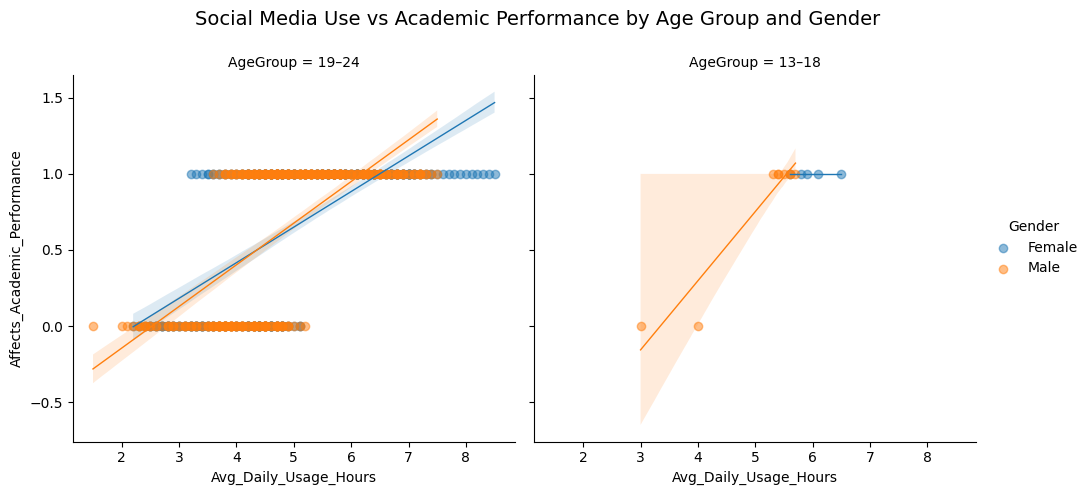

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert selected Spark DataFrame columns to Pandas DataFrame
# and remove rows with missing values
df_pandas = df.select(
    "Avg_Daily_Usage_Hours", 
    "Affects_Academic_Performance", 
    "Gender", 
    "Age"
).dropna().toPandas()

# Convert target column to numeric values
df_pandas["Affects_Academic_Performance"] = df_pandas["Affects_Academic_Performance"].map({"Yes": 1, "No": 0})

# Categorize age into age groups
df_pandas["AgeGroup"] = df_pandas["Age"].apply(
    lambda x: "13–18" if x <= 18 else "19–24"
)

# Plot: Regression analysis per age group, separated by gender
g = sns.lmplot(
    data=df_pandas,
    x="Avg_Daily_Usage_Hours",
    y="Affects_Academic_Performance",
    hue="Gender",
    col="AgeGroup",
    height=5,
    aspect=1,
    scatter_kws={"alpha": 0.5},
    line_kws={"linewidth": 1}
)

g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Social Media Use vs Academic Performance by Age Group and Gender", fontsize=14)
plt.show()





In [27]:
# select columns, and remove all the missing values
df_cleaned = df.select(
    "Avg_Daily_Usage_Hours",
    "Affects_Academic_Performance",
    "Gender",
    "Age"
).dropna()


In [23]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

# Convert Gender and Affects_Academic_Performance to numerical values
gender_indexer = StringIndexer(inputCol="Gender", outputCol="GenderIndex")
label_indexer = StringIndexer(inputCol="Affects_Academic_Performance", outputCol="label")

# Assemble features
assembler = VectorAssembler(
    inputCols=["Avg_Daily_Usage_Hours", "Age", "GenderIndex"],
    outputCol="features"
)

# Create Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="label")

# Create Pipeline
pipeline = Pipeline(stages=[gender_indexer, label_indexer, assembler, lr])

# Fit the model
model = pipeline.fit(df_cleaned)

# Make predictions
predictions = model.transform(df_cleaned)
predictions.select("Avg_Daily_Usage_Hours", "Age", "Gender", "prediction", "label").show(5)

# View model coefficients
lr_model = model.stages[-1]
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))


+---------------------+---+------+----------+-----+
|Avg_Daily_Usage_Hours|Age|Gender|prediction|label|
+---------------------+---+------+----------+-----+
|                  5.2| 19|Female|       0.0|  0.0|
|                  2.1| 22|  Male|       1.0|  1.0|
|                  6.0| 20|Female|       0.0|  0.0|
|                  3.0| 18|  Male|       1.0|  1.0|
|                  4.5| 21|  Male|       0.0|  0.0|
+---------------------+---+------+----------+-----+
only showing top 5 rows
Coefficients: [-2.521959377438985,0.3938912883876332,-0.5024398721023113]
Intercept: 3.072048548779507


/var/folders/l6/cpb5clzd2rs65n0mb1k_bn800000gn/T/ipykernel_53918/1162484985.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Academic Impact (1=Yes, 0=No)")


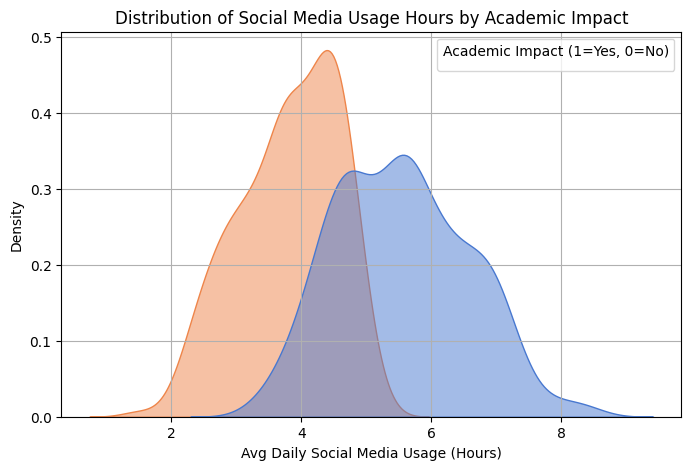

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure that 'Affects_Academic_Performance' is treated as a string
df_pandas["AAP_str"] = df_pandas["Affects_Academic_Performance"].astype(str)

# KDE Plot
plt.figure(figsize=(8, 5))
sns.kdeplot(
    data=df_pandas,
    x="Avg_Daily_Usage_Hours",
    hue="AAP_str",
    fill=True,
    common_norm=False,
    palette="muted",
    alpha=0.5
)

plt.title("Distribution of Social Media Usage Hours by Academic Impact")
plt.xlabel("Avg Daily Social Media Usage (Hours)")
plt.ylabel("Density")
plt.legend(title="Academic Impact (1=Yes, 0=No)")
plt.grid(True)
plt.show()
